# Microbial Fuel Cells

## By Brendon Trollip and Nico de Jongh

Microbial fuel cells (MFC) are bio-electrochemical systems mainly used to generate energy
from living electroactive bacteria or fungi due to their metabolic processes. It can also be
utilised to produce a certain product or for specific environmental advantages, such as
wastewater treatment [(Pinto, *et al*, 2010)](https://www.sciencedirect.com/science/article/abs/pii/S0960852410002087). One of the ways to curb climate change is to employ renewable bioenergy from wastes, resulting in a neutral or even negative carbon footprint. 

## How do MFC work?

Now that you are familiar with the reduction reaction of $NAD^{+}$ to NADH, we can now include it in our MFC discussion, [recap on NADH](https://www.youtube.com/watch?v=Kb-4uuCYLvE).
As we know by now mitochondria are the energy powerhouses of the cell by accumulating or releasing chemical energy in the form of substrates like NADH or NADPH. These substrates transfer electrons to the metabolites and when the process is carried out in anaerobic conditions, NADH and NADPH become electroactive [(Zhang & Halme,1995).](https://link.springer.com/article/10.1007%2FBF00129009)

![](Mitoc.gif)

The operating principle comprises of the division of the half reactions of oxidation and reduction in two separate compartments. In the anodic compartment, electroactive bacteria catalyse substrate by oxidation in anaerobic conditions and transfer the electrons to the electrode. These electrons then flow through an external electrical circuit to the cathodic compartment where oxygen is the electron acceptor and reduced in aerobic conditions. To ensure neutrality, the $H^{+}$ flows through a cation permeable membrane to the cathodic compartment [(Capodaglio, Cecconet & Molognoni, 2017.)](https://www.mdpi.com/2227-9717/5/4/73)  

![Figure 1: MFC diagram](MFCdiagram.png)

Let's have a look at the following equation in cmol balance form:

$$ C H_{2} O + NH_{3} \to C H_{1.8} O_{0.5} N_{0.2} + CO_{2} + H^{+} + e^{-} $$

#### This equation looks very familiar!

In the equation above glucose is the substrate used and ammonia is used as a nitrogen source for the bacteria. Although every bacteria has their very own chemical formula, we will be using that of the familiar biomass estimation, X. The only addition from previous work, is the hydrogen atom, represented as an electron and proton. Balancing this equation is done as in previous sections. Let's try and balance the above equation.

$$(-r_S)\ CH_2 O+(-r_A)\ NH_3 \to (r_{X})\ CH_{1.8} O_{0.5} N_{0.2} +(r_C)\ CO_2 + (r_H)\ H $$

As said earlier the proton and electron can be seen as a hydrogen atom for simplicity of the balance. The proton and electron will then have the same stoichiometric coefficient as hydrogen, as can be seen below,

$$ YH \to YH^{+} + Ye^{-} $$

The matrix will look at follows, 

$$\begin{bmatrix}-1&0&1&1&0\\-2&-3&1.8&0&1\\-1&0&0.5&2&0\\0&1&0.2&0&0\\1&0&0&0&0\end{bmatrix}\times\begin{bmatrix}-r_S\\-r_A\\r_{X}\\r_C\\r_H\end{bmatrix}=\begin{bmatrix}0\\0\\0\\0\\1\end{bmatrix}$$


And solving in python:

In [1]:
import numpy
S = numpy.matrix([[-1, 0, 1, 1, 0],  
                  [-2, -3, 1.8, 0,1], 
                  [-1, 0, 0.5, 2, 0],
                  [0, -1, 0.2, 0, 0],
                  [1, 0, 0, 0, 0]])

C = numpy.matrix([[0,0,0,0,1]]).T
Y = numpy.linalg.solve(S,C)
print(Y)
print(Y[0,0])
print (Y[1,0])

[[1.        ]
 [0.13333333]
 [0.66666667]
 [0.33333333]
 [1.2       ]]
1.0
0.13333333333333333


Thus the balanced equation will have the following form,

$$ CH_2 O+ \frac{2}{15} NH_3 \to  \frac{2}{3} CH_{1.8} O_{0.5} N_{0.2} + \frac{1}{3}CO_2 + 1.2H^+ +1.2e^- $$


As can be seen by the equation above, for every cmol of glucose, 1.2 mol electrons are formed that will flow through the external electrical circuit. We will now model the equation in a batch reactor using a similiar method to that what was used to model batch fermentation. As the volume in a batch reactor doesn't change, it creates very simple differential equations, adapted from  [(Pinto, *et al*, 2010)](https://www.sciencedirect.com/science/article/abs/pii/S0960852410002087). 

\begin{align*}
\text{Biomass: }&\frac{dC_X}{dt}=r_X C_X -K_dC_X\\
\text{Substrate: }&\frac{dC_S}{dt}=-r_S C_X \\
\text{Hydrogen: }&\frac{dC_H}{dt}=r_H C_X \\
\end{align*}

Where, S, is the substrate (glucose in this case) and X, is the biomass. $K_{d}$ is known as the bacterial endogenous decay coefficient and can be assumed to be 0.02 $\mu_{max}$. This will be considered later and for now it is assumed the bacteria doesn't decay. Monod kinetics are assumed for the growth of the bacteria using the following equation:

$$ \mu = \mu_{max} \frac{C_S}{K_M + C_S} $$

Let's try solving the differential equations. First we will define the required parameters:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
%matplotlib inline

MMX = 1*12 + 1.8*1 + 0.5*16 + 0.2*14

mu_max = 0.12
K_M = 0.0004

c_S_0 = 5/30
c_X_0 = 0.001/MMX
c_H_0 = 0/1
V_0 = 1

As can be observed by the cell above, the molar mass of the biomass is calculated. There are parameters given for $\mu_{max}$ and $K_{m}$, respectively. The initial values of the substrate, $C_{S}$ and biomass, $C_{X}$, is given in units of grams and then converted to cmols. As for the volume, it will stay unchanged at 1 L, as it is a batch reactor, but might change later when we consider CSTR's.

In [3]:
def rates(var):
    c_S, c_X, c_H, c_C, V = var
    
    mu = mu_max*c_S/(K_M + c_S)
    
    S_base = np.matrix([[1,    0,    1,     1,    0,  ],
                        [2,    3,    1.8,   0,    1,  ],
                        [1,    0,    0.5,   2,    0,  ],
                        [0,    1,    0.2,   0,    0   ]])
#                       rS,   rA,   rX,    rC,   rH  
#                       r[0], r[1], r[2],  r[3], r[4] 

    S_spec = [1, 0, 0, 0, 0] # S0
    A_spec = [0, 1, 0, 0, 0] # S1
    X_spec = [0, 0, 1, 0, 0] # S2
    C_spec = [0, 0, 0, 1, 0] # S3
    H_spec = [0, 0, 0, 0, 1] # S4
    
    S = np.vstack([S_base, X_spec])
    C = np.array([0, 0, 0, 0, mu])
    r = np.linalg.solve(S, C)
    return r

Here, the same first four rows of the matrix used above, is implemented. Anyone of the five specifications can be used. The specification of the biomass was implemented here, thus making the biomass our basis. `Numpy.vstack` allows you to add another row into an existing matrix. It is then solved as usual.

In [4]:
def ferm(var, t):
    c_S, c_X, c_H, c_C, V = var
    
    r_S, r_A, r_X, r_C, r_H = rates(var)

    dc_Sdt = r_S*c_X
    dc_Xdt = r_X*c_X
    dc_Hdt = r_H*c_X
    dc_Cdt = r_C*c_X
    dVdt = 0
    return dc_Sdt, dc_Xdt, dc_Hdt, dc_Cdt, dVdt

The three differential equations are now included in the 'ferm' function and ready to be integrated! Note, as stated earlier, the decay coefficient, $K_{d}$ will not be considered now.
As it is a batch reactor, the change in volume is zero. 

In [5]:
c_i_0 = [c_S_0, c_X_0, c_H_0, 0, V_0]
tspan = np.linspace(0.000001, 80, 101)

c_i = odeint(ferm, c_i_0, tspan)
c_S, c_X, c_H, c_C, V = c_i.T

The differential equation are solved using `odeint` from the `scipy.integrate` module.

Although the concentration of all the considered species, $C_{S}$, $C_{X}$ and $C_{H}$ have been calculated, we are interested in the rates of how they increase/decrease. We simply make lists and append the corresponding rate value to the list. Why we do this become apparent later...

In [6]:
list_cS = []
list_cX = []
list_cH = []

for i in range(0, len(c_S)):
    r_S, r_A, r_X, r_C, r_H = rates([c_S[i], c_X[i], c_H[i], c_C[i], V[i]])
    list_cS.append(r_S)
    list_cX.append(r_X)
    list_cH.append(r_H)
    
r_S = np.array(list_cS)
r_H = np.array(list_cH)

Finally, we plot our results.

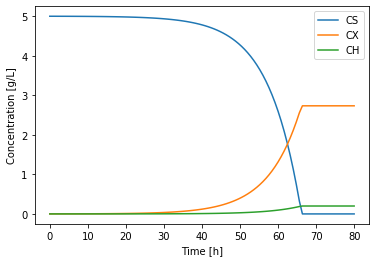

In [7]:
plt.plot(tspan, c_S*30, label = 'CS')
plt.plot(tspan, c_X*MMX, label = 'CX')
plt.plot(tspan, c_H*1, label = 'CH')
plt.ylabel('Concentration [g/L]')
plt.xlabel('Time [h]')
plt.legend()

Let's have a look at the following plot.

Text(0.5, 0, 'Time [h]')

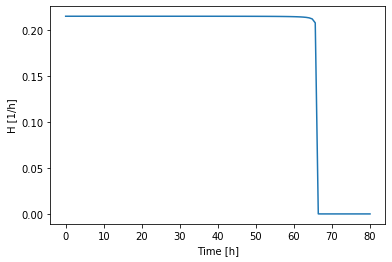

In [8]:
plt.plot(tspan, r_H)
plt.ylabel('H [1/h]')
plt.xlabel('Time [h]')

What do you see?


As we mentioned earlier, hydrogen consists of a proton and electron. The rate of hydrogen production stays constant at 0.216 $\frac{mol \ H}{cmol \ X \cdot h}$, but at t = 67 h, it drops to zero, due to glucose being depleted. To get a better look at the production of hydrogen we will plot $C_{H}$ vs time on its own axis.

Text(0.5, 0, 'Time [h]')

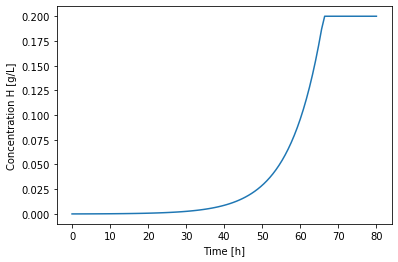

In [9]:
plt.plot(tspan, c_H*1, label = 'CH')
plt.ylabel('Concentration H [g/L]')
plt.xlabel('Time [h]')

How do you calculate current from here? Well, current has units of ampere, which is coulumb per second. If we dig deep enough into high school chemistry, there exists a relationship between moles and coulomb...


But don't make the mistake of using the molar or mass concentration to calculate the amperes, as dividing the concentration by time will give you a differential over the whole time span, rather than at every required time point in the list. Thus we will convert the biomass based rate of hydrogen production to an absolute hydrogen production rate value. We can do this by multiplying by the concentration of biomass and the volume. It will be easier to explain how the units check out visually.

$$ r_H [\frac{mol \ H}{cmol \ X \cdot h}] \times c_X [\frac{cmol \ X}{L}] \times V [L] \times \frac{h}{60 \ minutes}\times \frac{minutes}{60 \ seconds} = F_H [\frac{mol \ H}{s}]$$

Text(0.5, 0, 'Time [h]')

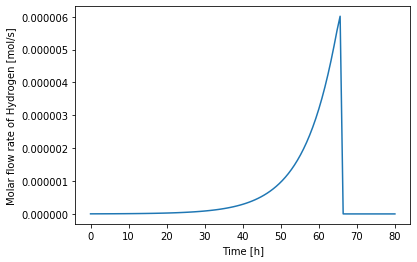

In [10]:
F_H = r_H*c_X*V*(1/60)*(1/60)

plt.plot(tspan, F_H)
plt.ylabel('Molar flow rate of Hydrogen [mol/s]')
plt.xlabel('Time [h]')

Taking this from a mass concentration to a molar concentration (it will effectively stay unchanged as the molar mass of hydrogen is 1). Now that we have a molar flow rate, $F_{H}$, we can go to the next step. Remember something called Avogadro's number? It can convert moles to atoms by multiplying by 6.022 $\times$ $10^{23}$. Let's calculate how many hydrogen atoms are present in the reactor at a specific time,

Text(0.5, 0, 'Time [h]')

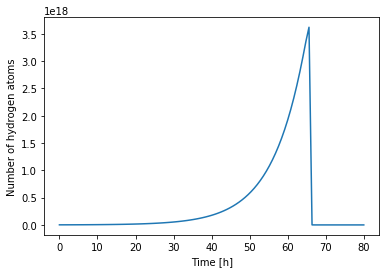

In [11]:
H_atoms = F_H*6.022e23
plt.plot(tspan, H_atoms)
plt.ylabel('Number of hydrogen atoms')
plt.xlabel('Time [h]')

Now comes the part that has been repeated numerous times. A hydrogen consists of a proton and an electron, this means the amount of hydrogen atoms equals the amount of electrons and the charge of one electron is equal to 1.60217646 $\times$ $10^{-19}$ coulomb and as stated earlier coulomb per second is ampere! And as we already have the number of hydrogen atoms and electrons in a per second basis, multiply by the charge of an electron will automatically give coulomb per second, which equates to amperes.

Text(0.5, 0, 'Time [h]')

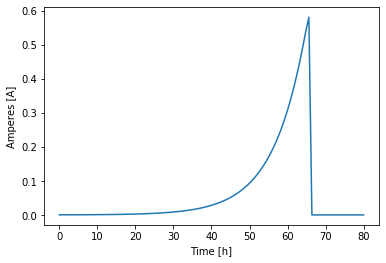

In [12]:
N_electrons = H_atoms
Coulomb_per_second = N_electrons*1.60217646e-19

Ampere = Coulomb_per_second

plt.plot(tspan, Ampere)
plt.ylabel('Amperes [A]')
plt.xlabel('Time [h]')

And there it is, the current produced over time from our biomass using glucose. Some interesting observations can be made. 

The amount of amperes produced, increases exponentially and then suddenly drops to zero at t = 67 h, due to the substrate being used up. This clearly shows us that there exists a clear link between substrate and current, when the substrate is depleted, the bugs can't produce any electrons and there will thus be no current. Eventhough the bacteria will still be alive for some time after the substrate is depleted, they won't be producing any current.

# Maximum voltage

But does that mean if we add 100 kg of glucose and ensure the bacteria never runs out of substrate we will be able to produce enough amperes to power a house?
Well, unfortunately, it doesn't work like that. As with everything in life, there exists a maximum and it will never exceed that limit. 

If we, again, go back to high school chemistry, we can remind ourselves of half reaction potential. This is the theoretical maximum voltage a cell can reach. If we know the resistance of our system we can then calculate the maximum current that can be produced as well. Here follows a standard reduction potential table of some reactions. We will assume that these voltages are valid at all concentrations, temperatures and pH values. 

![Figure 3: Redox table](redox.jpeg)

Reading the reaction from left to right will give you the reduction reaction and reading from right to left will give you the oxidation reaction. Let's use the glucose-oxygen redox reaction as in the example above. The amount of electrons on the right and the left should cancel out.

\begin{align*}
\text{Reduction: }&\frac{1}{2}O_2 + 2H^+ + 2e^- \to H_2O \ \times 2\\
\text{Oxidation: }&CH_2O + H_2O \to CO_2 + 4H^+ + 4e^- \\
\end{align*}

Now, 

\begin{align*}
\text{Reduction: }&O_2 + 4H^+ + 4e^- \to 2H_2O \ \\
\text{Oxidation: }&CH_2O + H_2O \to CO_2 + 4H^+ + 4e^- \\
\end{align*}

Cancel and writing as one equation,

\begin{align*}
\text{Redox reaction: }&CH_2O + O_2 \to CO_2 + H_2O\ \\
\end{align*}

And as we multiplied the reduction half reaction by 2, the voltage must also be multiplied by 2. Thus,

$$ E_{max} = 2\times820 - (-430) = 2070 \ mV = 2.07 \ V $$

Where $E_{max}$ is the maximum voltage that can be obtained, in this case 2.07 V.

The maximum current can also be calculated by using the following equation,

$$ I_{max} = \frac{E_{max}}{R_{ext}} $$

We will assume that $R_{ext}$ is much bigger than $R_{int}$ and thus we will only be considering $R_{ext}$. After calculating $I_{max}$, we can actually completly work back to calculate a maximum hydrogen production rate. Using the same method as above, we can calculate $r_{H, \ max}$ as follows, 

In [13]:
V_max = 2.07 #V
R = 500 #ohm (so big, rint is effec = 0)
I_max = V_max/R
N_elec_max = I_max/1.60217646e-19
F_H_max = N_elec_max/6.022e23
r_H_max = F_H_max/((1/60)*(1/60))
r_H_max

0.00015447270233862693

The maximum current that can actually be produced is,

In [14]:
print('I_max =', I_max, 'A')

I_max = 0.00414 A


So when this maximum voltage is reached, what happens to our bacteria? Well it will produce a maximum hydrogen rate, but what will happen then?


As the bacteria still wants to grow, but can't produce anymore hydrogen, another metabolic pathway will be followed. A new 'electron acceptor' must be used. The bacteria will actually then follow a fermentation pathway where ethanol and water is produced. This does not only happen theoritically, but practically as well, as one student realized for this CSC. This is a fully functioning MFC on day 1.

![](day1.jpeg)

And after 7 days, fermatation took place as can be seen by how opaque the water became. A strong alcohol odour could also be smelled at the top of the MFC, which is the ethanol being produced.

![](day7.jpeg)

Thus, we will have to modify our chemical equation from earlier to,

$$(-r_S)\ CH_2 O+(-r_A)\ NH_3 \to (r_{X})\ CH_{1.8} O_{0.5} N_{0.2} +(r_C)\ CO_2 + (r_H)\ H + (r_E)\ CH_3O_{0.5} + (r_W)\ H_2O$$

But now we can't calculate the stoicometric equations as they will be changing as the hydrogen is being produced. 
We will modify our 'rates' function as well and accommodate the  production of ethanol when the hydrogen production rate reaches a maximum. We will be adding an if statement for when the ethanol is produced.

In [15]:
MMX = 1*12 + 1.8*1 + 0.5*16 + 0.2*14

mu_max = 0.12
K_M = 0.0004

c_S_0 = 5/30
c_X_0 = 0.001/MMX
c_H_0 = 0/1
V_0 = 1

V_max = 2.07 #V
R = 500 #ohm (so big, r_internal is effec = 0)
I_max = V_max/R
N_elec_max = I_max/1.60217646e-19
F_H_max = N_elec_max/6.022e23
r_H_max = F_H_max/((1/60)*(1/60))
r_H_max

0.00015447270233862693

We are now adding an `if` statement to control the ethanol production. We also have to add another specification to our matrix to keep it square. For the case when the production of hydrogen is less than the maximum production of hydrogen, we add an ethanol specification by setting the production of ethanol to zero, as no ethanol will be produced. But as soon as the maximum rate of hydrogen is reached, we set the production of hydrogen to it's maximum value, allowing ethanol to be produced. We will assume that for every ethanol that is produced, two waters are formed as well. This is a specification we have to incorporate, otherwise we will have a singular matrix and no ethanol production. Thus, in the first matrix, water production is set to zero and in the second matrix water is set to half of that of ethanol.

In [16]:
def rates(var):
    c_S, c_X, c_H, c_E, c_C, c_W, V = var
    
    mu = mu_max*c_S/(K_M + c_S)
#     r_H_max = 0.00001
    
    S_base = np.matrix([[1,    0,    1,     1,    0,  1,   0],
                        [2,    3,    1.8,   0,    1,  3,   2],
                        [1,    0,    0.5,   2,    0,  0.5, 1],
                        [0,    1,    0.2,   0,    0,  0,   0]])
#                       rS,   rA,   rX,    rC,   rH   rE,  rW
#                       r[0], r[1], r[2],  r[3], r[4] r[5] r[6]

    S_spec = [1, 0, 0, 0, 0, 0, 0] # S0
    A_spec = [0, 1, 0, 0, 0, 0, 0] # S1
    X_spec = [0, 0, 1, 0, 0, 0, 0] # S2
    C_spec = [0, 0, 0, 1, 0, 0, 0] # S3
    H_spec = [0, 0, 0, 0, 1, 0, 0] # S4
    E_spec = [0, 0, 0, 0, 0, 1, 0] # S5
    W_spec = [0, 0, 0, 0, 0, 0, 1]
    Add_spec_1 = [0, 0, 0, 0, 0, -1, 0.5]
    
    S1 = np.vstack([S_base, X_spec, E_spec, W_spec])
    C1 = np.array([0, 0, 0, 0, mu, 0, 0]).T
    r = np.linalg.solve(S1, C1)
    
    if r_H_max > r[4]*c_X*V :
        return r
    
    else:
        S2 = np.vstack([S_base, X_spec, H_spec, Add_spec_1])
        C2 = np.array([0, 0, 0, 0, mu, r_H_max/c_X/V, 0]).T
        r = np.linalg.solve(S2, C2)
        
        return r

In [17]:
def ferm(var, t):
    c_S, c_X, c_H, c_E, c_C, c_W, V = var
    
    r_S, r_A, r_X, r_C, r_H, r_E, r_W = rates(var)

    dc_Sdt = r_S*c_X
    dc_Xdt = r_X*c_X
    dc_Hdt = r_H*c_X
    dc_Edt = r_E*c_X
    dc_Cdt = r_C*c_X
    dc_Wdt = r_W*c_X
    dVdt = 0
    return dc_Sdt, dc_Xdt, dc_Hdt, dc_Edt, dc_Cdt, dc_Wdt, dVdt

In [18]:
c_i_0 = [c_S_0, c_X_0, c_H_0, 0, 0, 0, V_0]
tspan = np.linspace(0.000001, 80, 101)

c_i = odeint(ferm, c_i_0, tspan)
c_S, c_X, c_H, c_E, c_C, c_W, V = c_i.T

In [19]:
list_rS = []
list_rA = []
list_rX = []
list_rC = []
list_rH = []
list_rE = []
list_rW = []

for i in range(0, len(c_S)):
    r_S, r_A, r_X, r_C, r_H, r_E, r_W = rates([c_S[i], c_X[i], c_H[i], c_E[i], c_C[i], c_W[i], V[i]])
    list_rS.append(r_S)
    list_rA.append(r_A)
    list_rX.append(r_X)
    list_rC.append(r_C)
    list_rH.append(r_H)
    list_rE.append(r_E)
    list_rW.append(r_W)
    
r_S = np.array(list_rS)
r_A = np.array(list_rA)
r_X = np.array(list_rX)
r_C = np.array(list_rC)
r_H = np.array(list_rH)
r_E = np.array(list_rE)
r_W = np.array(list_rW)

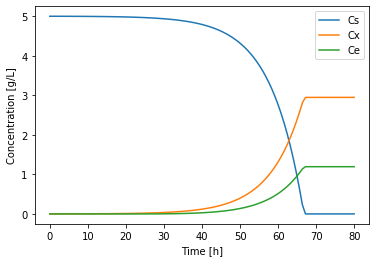

In [20]:
plt.plot(tspan, c_S*30, label = 'Cs')
plt.plot(tspan, c_X*MMX, label = 'Cx')
plt.plot(tspan, c_E*46, label = 'Ce')
plt.ylabel('Concentration [g/L]')
plt.xlabel('Time [h]')
plt.legend()

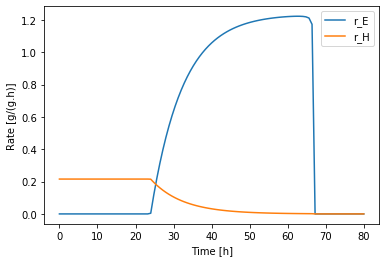

In [21]:
plt.plot(tspan, r_E*46, label = 'r_E')
plt.plot(tspan, r_H*1, label = 'r_H')
plt.ylabel('Rate [g/(g.h)]')
plt.xlabel('Time [h]')
plt.legend()

In the graph above, we can observe that the fermentation pathway was followed after about 24 hours, when ethanol starts being produced exponentially and the hydrogen concentration becomes a straight line (thus, the production rate of hydrogen stays constant). 

Text(0.5, 0, 'Time [h]')

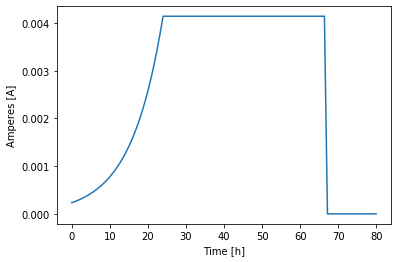

In [22]:
F_H = r_H*c_X*V*(1/60)*(1/60)
H_atoms = F_H*6.022e23
N_electrons = H_atoms
Coulomb_per_second = N_electrons*1.60217646e-19

Ampere = Coulomb_per_second

plt.plot(tspan, Ampere)
#plt.plot(tspan, r_E)
plt.ylabel('Amperes [A]')
plt.xlabel('Time [h]')

Finally, we can now see the current produced in the MFC. As we see here, the current increases exponentially for about 26 hours, it then reaches the asymptotic maximum of I_max, which was calculated as 0.00414 A previously. The current produced stays constant until the substrate is depleted, as stated earlier after 67 hours. 

# Energy considerations

By now we have considered all possible contributors to the current generated in a MFC, except energy. A wide variety of organic substrates can be metabolised by bacteria, such as lipids, proteins and carbohydrates, to provide the organism with enegry and a carbon-source. The production of ATP is governed by the organic substrate supplying electron donors for the redox reactions. Through numerous reactions, including glycolysis, the substrate is converted into acetyl–CoA. Transporting acetyl–CoA to the TCA cycle, which occurs in the cytoplasm, results in the reduction of $NAD^+$ and FAD to their electron carrier forms, NADH and $FADH_2$. Electrons are then transfered from the cytoplasm to the cell membrane by NADH and $FADH_2$. The following videos describe the process very well. 

[Electron transport chain](https://www.youtube.com/watch?v=xbJ0nbzt5Kw).

![](giphy.gif)

## Glycolysis

ATP is the key energy molecule for all living organisms. One source of ATP is glycolysis, a series of reactions that breaks down sugars to produce ATP. Glycolysis is a series of 10 reactions that convert sugars, like glucose, into 3 carbon molecules called pyruvate. Glycolysis is an important pathway for cells because it produces ATP and other products such as NADH and pyruvate, that can be used later to produce more ATP. NADH is formed by an enzyme called the dehydroganse, NADH is an electron carrier with the potential to produce more ATP. Glycolysis results in a net production of 2 ATP and 2 NADH per glucose molecule. 

## TCA cycle

Pyruvate provides the start of the TCA cycle, after glycolysis produced two pyruvate for every glucose, as can be observed in the figure below. 

![](TCA.png)

We now need to combine the whole process of ‘combusting’ glucose by looking at glycolysis, the TCA cycle and oxidative phosphorylation together. The overall equation for glycolysis and the TCA cycle is as follow:

$$C_6 H_{12} O_6+6H_2 O \to 6CO_2+10\,NADH+2\,FADH_2+4\, ATP$$

Two methods will be employed to incorporate energy into the system. 
- **Method 1:** The matrix still contains the familiar component (carbon, hydrogen, etc.) balances, but includes an energy spec in the matrix, which was calculated from the flux model.
- **Method 2:** The component balance will be replaced with a flux model that incorporates energy.


## Method 1

δ below represents the $(P/O)_{NADH}$, as described in Resperation in [this notebook](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/2%20Basic%20biochemistry/Basic%20Biochemistry.ipynb). A value of 1.4 was chosen as it will never reach the maximum of 3 $(P/O)_{NADH}$, due to the ATP distribution. The δ value will be specified and can vary between 0.5 and 2.5. 

As we are now considering the complete redox reaction, thus including the cathode's reduction reaction, all the $H^+$ produced during oxidation of the anode will be reduced with oxygen ($O_2$). This internal reaction tells us that the stoichiometric ratio will be,
\begin{align*}
\text{$H^+$  4:1  $O_2$}\\
\end{align*}
We will now consider a r_O_max rather than a r_H_max. The value will still be based on the r_H-max, but converted to a r_O_max using the above correlation. As $H^+$ is produced and $O_2$ is consumed, r_O_max will have the opposite sign of r_H_max, as can be seen below.
\begin{align*}
\text{r_O_max = -$\frac{1}{4}$r_H_max}\\
\end{align*}

In [23]:
MMX = 1*12 + 1.8*1 + 0.5*16 + 0.2*14

mu_max = 0.3
K_M = 0.001

δ = 0.5
γ = 2.4
α = 0.06


c_S_0 = 10/30
c_X_0 = 0.001/MMX
c_H_0 = 0/1
V_0 = 1.9

V_max = 2.07 #V
R = 500 #ohm (so big, r_internal is effec = 0)
I_max = V_max/R
N_elec_max = I_max/1.60217646e-19
F_H_max = N_elec_max/6.022e23
r_H_max = F_H_max/((1/60)*(1/60))
r_O_max = -r_H_max/4

The energy balance was based on the net ATP consumed and produced in glycolysis and the TCA cycle. As only biomass, $CO_2$ and water affects the energy balance in the TCA cycle. The following correlations in the `Energy_spec` was calculated from the following figure. 

![](willietca2f.png)

In the `S_base` matrix, rH has been replaced by rE, due to r_O_max now specifying the maximum voltage.
For the `S1` matrix, $\mu$, the growth rate is used as well as setting the ethanol production equal to zero, as previously stated. Another new spec, `Resp_spec` was used to specify that all the $CO_2$ produced from respiration, has the same rate as that of $O_2$. The `S2` matrix includes the new `Resp_spec`, `Energy_spec` and r_O_max. Finally, an if statement is included to ensure when the substrate is depleted, that all the other rates are equal to zero.

In [24]:
def rates(var):
    c_S, c_X, c_C, c_E, c_O, c_W, V = var
        
    mu = mu_max*c_S/(K_M + c_S)
    
    S_base = np.matrix([[1,    0,    1,     1,    1,    0,   0],
                        [2,    3,    1.8,   0,    3,    0,   2],
                        [1,    0,    0.5,   2,    0.5,  2,   1],
                        [0,    1,    0.2,   0,    0,    0,   0]])
#                        rS,   rA,   rX,    rC,   rE    rO,  rW
#                        r[0], r[1], r[2],  r[3], r[4]  r[5] r[6]

    S_spec = [1, 0, 0, 0, 0, 0, 0] # S0
    A_spec = [0, 1, 0, 0, 0, 0, 0] # S1
    X_spec = [0, 0, 1, 0, 0, 0, 0] # S2
    C_spec = [0, 0, 0, 1, 0, 0, 0] # S3
    E_spec = [0, 0, 0, 0, 1, 0, 0] # S4
    O_spec = [0, 0, 0, 0, 0, 1, 0] # S5
    W_spec = [0, 0, 0, 0, 0, 0, 1] # S6
    Resp_spec = [0, 0, -α, 1, -1/2, -1, 0]
    Energy_spec =  [0, 0, -γ, 2/3, 1, -2*δ, 0]
    
    S1 = np.vstack([S_base, X_spec, E_spec, Resp_spec])
    C1 = np.array([0, 0, 0, 0, mu, 0, 0]).T
    r = np.linalg.solve(S1, C1)
    
    if c_S > 0.000001:
        
        if r_O_max < r[5]*c_X*V:
            return r

        else:
            S2 = np.vstack([S_base, O_spec, Resp_spec, Energy_spec])
            C2 = np.array([0, 0, 0, 0, r_O_max/c_X/V, 0, 0]).T
            r = np.linalg.solve(S2, C2)
            return r
    
    else:
        S3 = np.vstack([S_base, S_spec, X_spec, E_spec])
        C3 = np.array([0, 0, 0, 0, 0, 0, 0]).T
        r = np.linalg.solve(S3, C3)
        return r

In [25]:
def ferm(var, t):
    c_S, c_X, c_C, c_E, c_O, c_W, V = var
    
    r_S, r_A, r_X, r_C, r_E, r_O, r_W = rates(var)
    
    dc_Sdt = r_S*c_X
    dc_Xdt = r_X*c_X
    dc_Cdt = r_C*c_X
    dc_Edt = r_E*c_X
    dc_Odt = r_O*c_X
    dc_Wdt = r_W*c_X
    dVdt = 0
    
    return dc_Sdt, dc_Xdt, dc_Cdt, dc_Edt, dc_Odt, dc_Wdt, dVdt

In [26]:
c_i_0 = [c_S_0, c_X_0, 0, 0, 0, 0, V_0]
tspan = np.linspace(0.000001, 50, 1001)

c_i = odeint(ferm, c_i_0, tspan)
c_S, c_X, c_C, c_E, c_O, c_W, V = c_i.T
c_S_mb, c_X_mb, c_C_mb, c_E_mb, c_O_mb, c_W_mb, V = c_S, c_X, c_C, c_E, c_O, c_W, V

In [27]:
list_rS = []
list_rA = []
list_rX = []
list_rC = []
list_rE = []
list_rO = []
list_rW = []

for i in range(0, len(c_S)):
    r_S, r_A, r_X, r_C, r_E, r_O, r_W = rates([c_S[i], c_X[i], c_E[i], c_O[i], c_C[i], c_W[i], V[i]])
    list_rS.append(r_S)
    list_rA.append(r_A)
    list_rX.append(r_X)
    list_rC.append(r_C)
    list_rE.append(r_E)
    list_rO.append(r_O)
    list_rW.append(r_W)
    
r_S = np.array(list_rS)
r_A = np.array(list_rA)
r_X = np.array(list_rX)
r_C = np.array(list_rC)
r_E = np.array(list_rE)
r_O = np.array(list_rO)
r_W = np.array(list_rW)

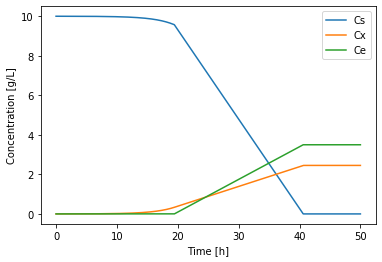

In [28]:
plt.plot(tspan, c_S_mb*30, label = 'Cs')
plt.plot(tspan, c_X_mb*MMX, label = 'Cx')
plt.plot(tspan, c_E_mb*23, label = 'Ce')

plt.ylabel('Concentration [g/L]')
plt.xlabel('Time [h]')
plt.legend()

The figure produced above is similiar to the figure with no energy considerations. The substrate is consumed exponentially in the first regime, where no fermentation takes place. When the maximum hydrogen consumption is reached, the fermentative pathway is followed and the concentrations increase/decrease linearly.

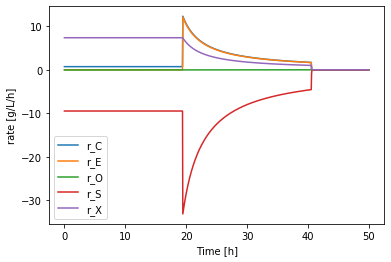

In [29]:
plt.plot(tspan, r_C*44, label = 'r_C')
plt.plot(tspan, r_E*23, label = 'r_E')
plt.plot(tspan, r_O*32, label = 'r_O')
plt.plot(tspan, r_S*30, label = 'r_S')
plt.plot(tspan, r_X*MMX, label = 'r_X')

plt.ylabel('rate [g/L/h]')
plt.xlabel('Time [h]')
plt.legend()

The oxygen consumption rate (r_O) is then converted back to a hydrogen production rate to be able to calculate the current produced.

Text(0.5, 0, 'Time [h]')

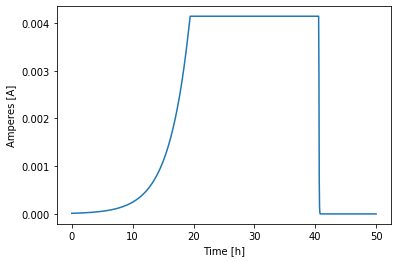

In [30]:
F_H = (-4*r_O)*c_X*V*(1/60)*(1/60)
H_atoms = F_H*6.022e23
N_electrons = H_atoms
Coulomb_per_second = N_electrons*1.60217646e-19

Ampere = Coulomb_per_second

plt.plot(tspan, Ampere)
plt.ylabel('Amperes [A]')
plt.xlabel('Time [h]')

In the figure above, a similiar plot is produced to the current-graph when energy was neglected. The figure reached the maximum-current plateau after 19 hours and the substrate was depleted just after 40 hours. As the parameters of $\mu_{max}$, the growth rate maximum was increased for this model (from 0.12 to 0.3), the consumption/production rates increased and thus the maximum current asymptote was achieved earlier than the graph with no energy considerations. 

## Method 2

As stated above, Method 2, uses a flux model balance, which includes energy consumption and production, according to the figure below. This method is described in great detail in the following [notebook.](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/4%20Stoichiometry%20that%20includes%20internal%20reactions/Main%20fermentative%20pathways.ipynb) The cmol flux map, as shown below, incorporates energy considerations for both NADH and ATP. It is a simpler way to include energy in the matrix for integration. The principle working of the flux model, is a balance on each node, that represents a rate. 

![](brentcaf.png)

The new parameter, θ, is a physiological property of the microbe that quantifies the mols of ATP spent on maintenance per hour per cmol of biomass:

$$ \theta \Rightarrow \frac{mol \,ATP}{cmol \,X \cdot h}$$

The other new parameter, $\beta$ is known as the amount of NADH produced per cmol of biomass:

$$ \beta \Rightarrow \frac{mol \,NADH}{cmol \,X \cdot h}$$

Beta can be calculated by doing a [degree of reduction balance (DOR)](https://nbviewer.jupyter.org/github/willienicol/Biochemical-engineering-notes/blob/master/3%20Stoichiometry%20without%20internal%20reactions/Degree%20of%20reduction%20balances.ipynb), with a basis of 1 cmol biomass, the equation can be solved using fsolve, as shown below. Remember that components such as $CO_2$ and $H_2$ has a DOR of 0. Remind ourselves that the DOR method uses set oxidation states of carbon ($+4$), hydrogen ($+1$), oxygen ($-2$) and nitrogen ($-3$) to perform the hydrogen and oxygen balances in a single balance by excluding water.

$$Glucose_{DOR} = Biomass_{DOR} + NADH_{DOR} $$


$$ 4(1+\alpha) = (4 + 1\cdot(1.8) - 2\cdot(0.5) - 3\cdot(0.2)) + 2 \cdot \beta  $$

Finally, $\alpha$ is the fracion of glucose consumed to produce carbon dioxide and should thus be included in the flux balance.

In [31]:
from scipy.optimize import fsolve
MMX = 1*12 + 1.8*1 + 0.5*16 + 0.2*14

mu_max = 0.3
K_M = 0.001

δ = 0.5
γ = 2.4
α = 0.09

θ = 0.1

def beta(β):
    nul1 = (1 + α)*4 - ((4 + 1*1.8 - 2*0.5 - 3*0.2) + 2*β)
    return nul1
β = fsolve(beta, α)[0]

c_S_0 = 10/30
c_X_0 = 0.001/MMX
c_H_0 = 0/1
V_0 = 1

V_max = 2.07 #V
R = 500 #ohm (so big, r_internal is effec = 0)
I_max = V_max/R
N_elec_max = I_max/1.60217646e-19
F_H_max = N_elec_max/6.022e23
r_H_max = F_H_max/((1/60)*(1/60))
r_H_max
r_O_max = -r_H_max/4

As stated above, the `S_base` matrix now consists of a energy-flux model and is no longer based on a component balance. The first row represents a carbon balance over node 0 and node 1. Other than ethanol which contains 2 carbons, all the components are already represented in terms of cmols and thus granted a value of 1. The second row represents a NADH balance for biomass at node 1, oxygen ($O_2$) at node 4 and $CO_2$ through the whole cycle. The final row represents an ATP balance, as shown below, 

$$ \gamma\cdot r_1 \ + \ \frac{2}{3}\cdot r_2 \ + \ (\frac{2}{3})(\frac{3}{2})\cdot r_3 \ + \ 2\delta\cdot r_4\ = \ \theta $$

where $\delta$, represents $(P/O)_{NADH}$

The familiar, `O_spec` and `Resp_spec`, which, again, specifies that all the $CO_2$ produced from respiration, has the same rate as that of $O_2$, was used as specifications for the matrix.

In [32]:
def rates(var):
    c_S, c_X, c_C, c_E, c_O_flux = var
        
    mu = mu_max*c_S/(K_M + c_S)
    
    S_base = np.matrix([[-1,   1+α,    1,    3/2,    0],
                        [0,    β,      2,    0,    -2],
                        [0,    -γ,   2/3,    1,   2*δ]])
#                       rS,    rX,    rC,   rE,   rO
#                       r[0], r[1], r[2],  r[3], r[4] 

    S_spec = [1, 0, 0, 0, 0] # S0
    X_spec = [0, 1, 0, 0, 0] # S1
    C_spec = [0, 0, 1, 0, 0] # S2
    E_spec = [0, 0, 0, 1, 0] # S3
    O_spec = [0, 0, 0, 0, 1] # S4
    Resp_spec = [0, 0, 1, 0, 1]   
    
    S1 = np.vstack([S_base, X_spec, Resp_spec])
    C1 = np.array([0, 0, θ, mu, 0]).T
    r = np.linalg.solve(S1, C1)  
    
#     return r
    if -r_O_max > r[4]*c_X:
        return r
    
    else:
        S2 = np.vstack([S_base, O_spec, Resp_spec])
        C2 = np.array([0, 0, θ, -r_O_max/c_X, 0]).T
        r = np.linalg.solve(S2, C2)
        
    return r

As you can see, we are not using a r_X, r_S, etc. rate, but rates number from 0 to 4, representing the nodes. The rate numbers are then converted to rates representing the compounds by adding or subtracting the rates that contain the specified component.

In [33]:
def ferm(var, t):
    c_S, c_X, c_C, c_E, c_O_flux = var
    
    r_0, r_1, r_2, r_3, r_4 = rates(var)

    if c_S < 0.000001:
        r_0, r_1, r_2, r_3, r_4 = 0, 0, 0, 0, 0
    
    r_S = -r_0
    r_X = r_1
    r_C = α*r_1 + r_2 + 1/2*r_3
    r_E = r_3
    r_O_flux = -r_4
    
    dc_Sdt = r_S*c_X
    dc_Xdt = r_X*c_X
    dc_Cdt = r_C*c_X
    dc_Edt = r_E*c_X
    dc_Odt = r_O_flux*c_X
    dVdt = 0

    return dc_Sdt, dc_Xdt, dc_Cdt, dc_Edt, dc_Odt

In [34]:
c_i_0 = [c_S_0, c_X_0, 0, 0, 0]
tspan = np.linspace(0.000001, 50, 1001)

c_i = odeint(ferm, c_i_0, tspan)
c_S, c_X, c_C, c_E, c_O_flux = c_i.T

In [35]:
list_rS = []
list_rX = []
list_rC = []
list_rE = []
list_rO = []

for i in range(0, len(c_S)):
    r_0, r_1, r_2, r_3, r_4 = rates([c_S[i], c_X[i], c_C[i], c_E[i], c_O_flux[i]])
    
    if c_S[i] < 0.000001:
        r_0, r_1, r_2, r_3, r_4 = 0, 0, 0, 0, 0
    
    r_S = -r_0
    r_X = r_1
    r_C = α*r_1 + r_2 + 1/2*r_3
    r_E = r_3
    r_O_flux = -r_4
    
    list_rS.append(r_S)
    list_rX.append(r_X)
    list_rC.append(r_C)
    list_rE.append(r_E)
    list_rO.append(r_O_flux)
    
r_S = np.array(list_rS)
r_X = np.array(list_rX)
r_C = np.array(list_rC)
r_E = np.array(list_rE)
r_O_flux = np.array(list_rO)

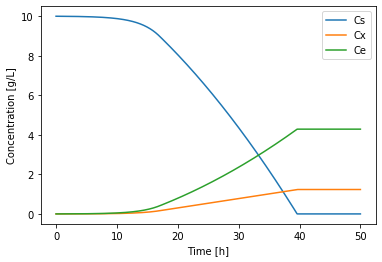

In [36]:
plt.plot(tspan, c_S*30, label = 'Cs')
plt.plot(tspan, c_X*MMX, label = 'Cx')
plt.plot(tspan, c_E*23, label = 'Ce')

plt.ylabel('Concentration [g/L]')
plt.xlabel('Time [h]')
plt.legend()

The concentration plot is similiar to method 1's figure. This is an indication that the two methods were implemented correctly, due to their similiar plots when two completely different approaches were taken. A more in depth comparison will be done in the next section.

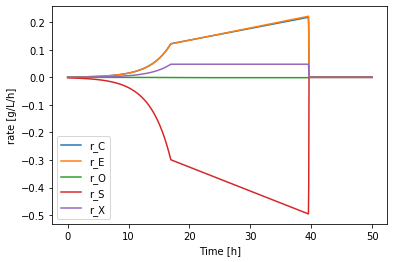

In [37]:
plt.plot(tspan, r_C*c_X*44, label = 'r_C')
plt.plot(tspan, r_E*c_X*23, label = 'r_E')
plt.plot(tspan, r_O_flux*c_X*32, label = 'r_O')
plt.plot(tspan, r_S*c_X*30, label = 'r_S')
plt.plot(tspan, r_X*c_X*MMX, label = 'r_X')

plt.ylabel('rate [g/L/h]')
plt.xlabel('Time [h]')
plt.legend()

Text(0.5, 0, 'Time [h]')

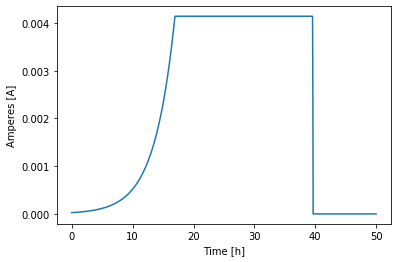

In [38]:
F_H_f = (-4*r_O_flux)*c_X*(1/60)*(1/60)
H_atoms_f = F_H_f*6.022e23
N_electrons_f = H_atoms_f
Coulomb_per_second_f = N_electrons_f*1.60217646e-19

Ampere_f = Coulomb_per_second_f

plt.plot(tspan, Ampere_f)
plt.ylabel('Amperes [A]')
plt.xlabel('Time [h]')

Again, the current plot above is reminiscent to the graph produced by method 1. After 17 hours, the current reaches the maximum value of 0.00414 A and after 40 hours the substrate is completely depleted and thus no current is produced.

## Comparison of methods

A comparison between the two methods can be seen in the figure below. The same initial values were used to make the methods comparable.

### Current produced

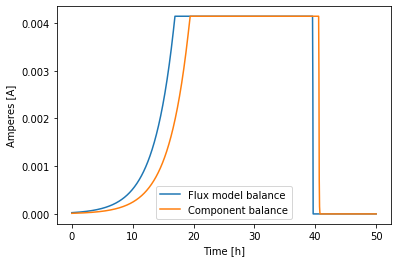

In [39]:
plt.plot(tspan, Ampere_f, label = 'Flux model balance')
plt.plot(tspan, Ampere, label = 'Component balance')
plt.ylabel('Amperes [A]')
plt.xlabel('Time [h]')
plt.legend()

Plotting the two different model approaches' current production on a singular graph clearly shows that the models produce almost the extact same results when all the initial parameters are the same. The method based on the flux model (method 1) reaches the maximum current only 2 hrs quicker, which is just a 4% difference. Also, the flux model's substrate is depleted first followed by the component balance method (method 2) a mere 49 minutes later, a 1.63% difference. 

By changing the $\alpha$ and $\mu_{max}$ for the two data sets, two identical current graphs can be produced for the two models. 

### T-Distribution test

Assuming all conditions of inference are met, a two sample t-test will be conducted to see if there is evidence that the two data sets, of current produced, are similiar. The null hypothesis is going to be the situation when there is no difference between the two data sets thus,

$$H_0: \mu_1 = \mu2 $$

and the alternative hypothesis being the current produce aren't similiar, 

$$H_A: \mu_1 \neq \mu2 $$

A significance level of \$alpha$ = 0.9 will be assumed as visually we can see that the data is very similiar. The following formula will be used to calculate the t-value, 

$$ t = \frac{X_2-X_1}{\sqrt{\frac{S_2^2}{N_2}-\frac{S_1^2}{N_1}}}$$

where $X_i$ is the mean of method i, $S_i$ is the standard deviation of method i and $N$ is the number of points.

In [40]:
X1 = numpy.mean(Ampere)
X2 = numpy.mean(Ampere_f)

S1 = numpy.std(Ampere)
S2 = numpy.std(Ampere_f)

t = (X2-X1)/numpy.sqrt((S2**2)/1001 - (S1**2)/1001)
print('t =', t)

t = 88.75687296862432


Using a [2-sample t-distribution calculator](https://stattrek.com/online-calculator/t-distribution.aspx), with the degrees of freedom, $df$ = 1000 ($df = N -1$ ) and a t-value of 88.757,

$$ P(t < 88.787) = 1.0000 $$

P(t < 88.787) > \$alpha$ thus, the null hypothesis will be accepted, proving statistically that the 2 data sets are similiar and thus the two models are almost identical. This proves that there exists a specific $\alpha$ and $\mu_{max}$ value for each of the models, where the models results will be identical.

### Concentration profiles

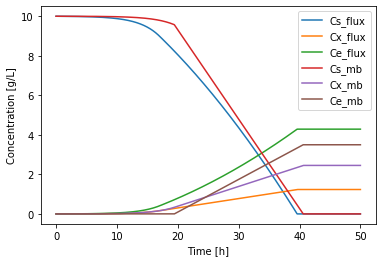

In [41]:
plt.plot(tspan, c_S*30, label = 'Cs_flux')
plt.plot(tspan, c_X*MMX, label = 'Cx_flux')
plt.plot(tspan, c_E*23, label = 'Ce_flux')
plt.plot(tspan, c_S_mb*30, label = 'Cs_mb')
plt.plot(tspan, c_X_mb*MMX, label = 'Cx_mb')
plt.plot(tspan, c_E_mb*23, label = 'Ce_mb')

plt.ylabel('Concentration [g/L]')
plt.xlabel('Time [h]')
plt.legend()

Comparing the two model's concentration profiles, it is clear that they produce almost exactly the same concentrations for the individual components. As proved by the t-test above, there exists two separate $\alpha$ and $\mu_{max}$ values for the 2 models, where the data will be exactly the same.

As stated earlier, the flux-model (method 1) reached the maximum current first and thus the concentration profile of the components will enter the second regime (the fermentative pathway) first. 

# Initial CSC experiments and preliminary results

As the University was placed under lockdown during the Covid-19 pandemic, the experimentation could not be completed, but some interesting result could be salvaged.

# Initial research

## Electrochemically active bacteria 

Most cultures used to form an electrochemically active biofilm on the anode is used in sterile environments with known bacteria. This can be both advantageous and disadvantageous using single or known cultures. As previous studies have been conducted on numerous bacteria and their ideal growth, it is advantageous to know what the perfect environment and substances fed, are. Contrarily, mixed cultures are more appropriate when complicated fuels such as wastewater is used, as single organisms can only metabolize some of the organic components [(Kim *et al*, 2007)](https://link.springer.com/article/10.1007/s00253-007-1027-4).  

*G. sulfurreducens* strain PCA has been successfully inoculated in sterile conditions with an incubation temperature of 30 ºC and pH of 6.8 [(Bond *et al*, 2003)](https://aem.asm.org/content/69/3/1548). A complex salt medium was used, thereafter 40 mM fumarate was added as an electron acceptor before transferring the bacteria into electrode-containing chambers. 

[Kim *et al*, 2007](https://link.springer.com/article/10.1007/s00253-007-1027-4) discussed numerous experiments conducted on different single cultures, with *Shewanella oneidensis* providing the highest power density. *Shewanella oneidensis* is a Fe (III)-reducing bacteria commonly found in marine environments, having an odour similar to rotten fish.  


**Table 1**: Maximum power density in various MFC’s using single cultures [(Kim *et al*, 2007)](https://link.springer.com/article/10.1007/s00253-007-1027-4)

![](MaxPwr.png)

## Electrode material

Numerous electrode designs and materials have been successfully used and generated electron transfer between the anode and cathode. The characteristics of the anode influences the biofilm formation and thus the appropriate material should be chosen [(Kim *et al*, 2007)](https://link.springer.com/article/10.1007/s00253-007-1027-4). 
Graphite felt is most commonly used, usually with some sort of mesh to allow bacteria to latch and form a biofilm. Helder et al, 2010 placed gold wire woven on the anode to increase electron transfer. 

Anodes can be optimized by biological or electrochemical means [(Rabaey *et al*, 2003)](https://link.springer.com/article/10.1023/A:1025484009367). By soaking electrodes in a diluted HCl-solution, most Fe(II)-ions can be extracted. Most bacteria can only reduce Fe(III) and not Fe(II)-ions [(Bond *et al*, 2003)](https://aem.asm.org/content/69/3/1548). Graphite electrodes can be optimized by adding MnO2 to the electrode. 


## Possible experimental set-up and considerations 

As for MFC, most chambers have been built out of Perspex tubes with varying diameters. Some MFC utilize a selective member for increased proton transfer and movement. It should be used with caution as the dissociation of cations, from the growth medium, such as $K^+$, $Na^+$ and $NH4^+$ among others are typically in the region of 105 times higher than $H^+$. The cations can interfere with protons movement and transfer through the selective membrane [(Kim *et al*, 2007)](https://link.springer.com/article/10.1007/s00253-007-1027-4). This can become a major problem with P-MFC, as plants are mostly fed a Hoagland solution containing numerous cations. 
MFC consists of a single-or double chamber for the electrodes, with single chamber MFC being the most popular. The anode is placed at the bottom of the chamber, thus creating anaerobic conditions due to oxygen diffusion. For good electrical conductivity containers can be filled with a 2:1 volume ratio of graphite and vermiculite granules. An extra layer of vermiculate can be placed before the cathode to prevent electrical contact between the cathode and anode [(Arends *et al*, 2012)](https://pubmed.ncbi.nlm.nih.gov/21958308/). The cathode must be placed at the top of the chamber in aerobic conditions to be able to reduce oxygen. The external resistive load connecting the cathode and anode vary between 10 Ω and 900 Ω [(Helder *et al*, 2013)](https://www.sciencedirect.com/science/article/pii/S0961953412004333). A Ag/AgCl electrode is normally used as a reference electrode between the anode and cathode. A multimeter is used to measure potential over the reference electrode.

## References

Arends, J.B. and Verstraete, W., 2012. 100 years of microbial electricity production: three concepts for the future. *Microbial Biotechnology*, 5(3), pp.333-346.

Bond, D.R. and Lovley, D.R., 2003. Electricity production by Geobacter sulfurreducens attached to electrodes. *Appl. Environ. Microbiol.*, 69(3), pp.1548-1555.

Helder, M., Strik, D.P.B.T.B., Hamelers, H.V.M., Kuhn, A.J., Blok, C. and Buisman, C.J.N., 2010. Concurrent bioelectricity and biomass production in three Plant-Microbial Fuel Cells using Spartina anglica, Arundinella anomala and Arundo donax. *Bioresource technology*, 101(10), pp.3541-3547.

Helder, M., Strik, D.P., Timmers, R.A., Raes, S.M., Hamelers, H.V. and Buisman, C.J., 2013. Resilience of roof-top plant-microbial fuel cells during Dutch winter. *Biomass and bioenergy*, 51, pp.1-7.

Kim, B.H., Chang, I.S. and Gadd, G.M., 2007. Challenges in microbial fuel cell development and operation. *Applied microbiology and biotechnology*, 76(3), p.485.

Rabaey, K., Lissens, G., Siciliano, S.D. and Verstraete, W., 2003. A microbial fuel cell capable of converting glucose to electricity at high rate and efficiency. *Biotechnology letters*, 25(18), pp.1531-1535.

# Experimental method 

As cabron felt was unavailable due to Covid-19, the anode was made of stainless steel exhaust pipe mesh, which was rolled tightly together and a copper wire was soldered onto it. The anode was placed in a 1M hydrochloric acid solution and heat treated with a blow torch to form more sites for the bacteria to latch on and form a biofilm. The cathode was also made out of the mesh, but with no treatment as only oxygen is reduced on the cathode.

A lead-based culture, obtained from lead wastewater, was inoculated on 14 February 2020. An inoculum temperature of 37 ºC was used with Luria-Bertani (LB) Broth as nutrient medium on a 25 g l-1 basis for 5 days. The anode was then placed inside the inoculum for another 5 days, and fed a 1:1:1:0.5 mixture of acetic acid, malic acid, succinic acid and yeast extract on a $1 \ g l^{-1} d^{-1}$, respectively. This allowed the bacteria to form a bioflim on the anode. The anode was then placed inside of a cylindrical tube with the cathode connected, to form the MFC. The signal chamber MFC (diameter = 93 mm and  height = 280 mm) was made from Perspex, with the anode at the bottom (anaerobic conditions) and the cathode at the surface of the solution (aerobic conditions). The solution used in the chamber was a variation of the Hoagland solution, consisting of 0.1 g/L calcium nitrate, 1 g/L monopotassium phosphate, 0.5 g/L magnesium sulfate heptahydrate, 0.01 g/L iron(II) sulfate, 0.005 g/L sodium molybdate, 0.5 g/L ammonium sulfate and sodium hydroxide to get a pH of 7.

For the batch MFC, 0.045 mol (8.92 g) glucose monohydrate was added, which equates to 8.11 g glucose. The external circuit connected the anode to the cathode with variable external resistances available, as can be seen in the imagebelow. The internal resistance was measured at 120 $\Omega$. Periodic voltage measurements were manually taken over 100 and 1000 $\Omega$ resistors, respectively. 

To ensure that the lead based culture was producing the current observed, a control run was also performed in which the anode had no biofilm and was mearly placed in the MFC. The exact same solution and initial glucose amount was used.


![](setup.jpeg)

## Unsuccessful inoculations 

For the inital inoculation attempt, a mixed culture was obtained from the small dam at Engineering 3, University of Pretoria (25.7541° S, 28.2265° E). The mixed culture was inoculated for 10 days using a feeding rate of $4 \ g l^{-1} d^{-1}$ glucose and $2 \ g l^{-1} d^{-1}$ yeast extract, purged with air to ensure aerobic growth. Unfortunately, the bacteria grew over the holes of the air stone and blocked the holes, this resulted in anaerobic growth and unwanted fermentation. It is thought to be the result of the glucose allowing the bacteria to follow the fermentation pathway. 

A new mixed culture was then inoculated on 10 February 2020 and fed a 1:1:1:0.5 mixture of acetic acid, malic acid, succinic acid and yeast extract on a $1 \ g l^{-1} d^{-1}$, respectively. This mixture was adapted from Arends et al, 2014 to reduce anaerobic growth with the exclusion of glucose. No fermentation was observed, but the bacteria didn't latch on the anode, which was made of stainless steel exhaust pipe mesh, as no carbon felt could be obtained from China due to Covid-19. The exhaust pipe mesh was thought to be too smooth and thus the bacteria couldn't latch. An one molar hydrochloric was made and the mesh was placed inside the solution overnight. This resulted in the mesh becoming more rough, allow sites for the bacteria to latch on and form a biofilm on the anode.

## Experimental results

Please see attached excel document for all calculations.

### Lead-based culture biofilm on anode

In [42]:
ΔT = numpy.array([0,114,196,398,1282,1618,2210])

V_100ohm = numpy.array([0.025,0.044,0.029,0.018,0.012,0.011,0.007])
mA_100ohm = numpy.array([0.114,0.200,0.132,0.082,0.055,0.050,0.032])


V_1000ohm = numpy.array([0.136,0.182,0.173,0.130,0.129,0.112,0.084])
mA_1000ohm = numpy.array([0.121,0.163,0.154,0.116,0.115,0.100,0.075])

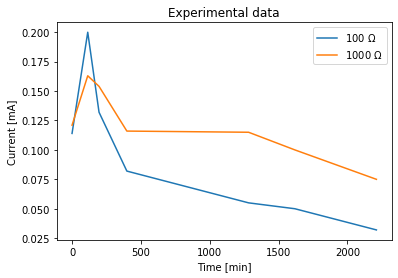

In [43]:
plt.plot(ΔT, mA_100ohm, label = '100 $\Omega$')
plt.plot(ΔT, mA_1000ohm, label = '1000 $\Omega$')
plt.xlabel('Time [min]')
plt.ylabel('Current [mA]')
plt.title('Experimental data')
plt.legend()

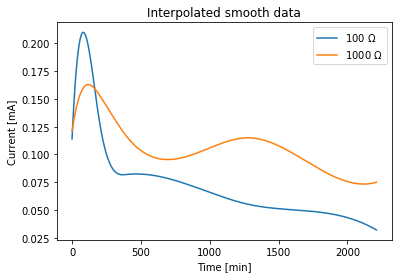

In [44]:
from scipy.interpolate import make_interp_spline, BSpline

# 300 represents number of points to make between T.min and T.max
xnew = np.linspace(ΔT.min(), ΔT.max(), 300)  

spl100 = make_interp_spline(ΔT, mA_100ohm, k=3)
spl1000 = make_interp_spline(ΔT, mA_1000ohm, k=3)

smooth100ohm = spl100(xnew)
smooth1000ohm = spl1000(xnew)

plt.plot(xnew, smooth100ohm, label = '100 $\Omega$')
plt.plot(xnew, smooth1000ohm, label = '1000 $\Omega$')
plt.xlabel('Time [min]')
plt.ylabel('Current [mA]')
plt.title('Interpolated smooth data')
plt.legend()

### Controlled run

In [45]:
ΔTc = numpy.array([0,230,1610,3110,4400,5810,7130,8510])

mVc_100ohm = numpy.array([2.5,2.4,3.6,0.9,3.9,1.8,5.3,5.5])
mAc_100ohm = numpy.array([0.011,0.011,0.016,0.004,0.018,0.008,0.024,0.025])

mVc_1000ohm = numpy.array([13.6,18,47.7,12.2,23.8,8.2,32.1,40.9])
mAc_1000ohm = numpy.array([0.012,0.016,0.043,0.011,0.021,0.007,0.029,0.037])

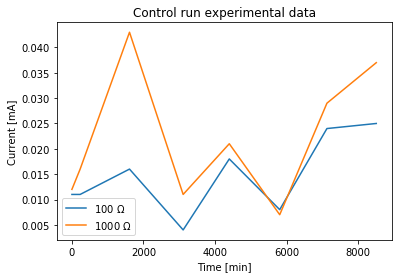

In [46]:
plt.plot(ΔTc, mAc_100ohm, label = '100 $\Omega$')
plt.plot(ΔTc, mAc_1000ohm, label = '1000 $\Omega$')
plt.xlabel('Time [min]')
plt.ylabel('Current [mA]')
plt.title('Control run experimental data')
plt.legend()

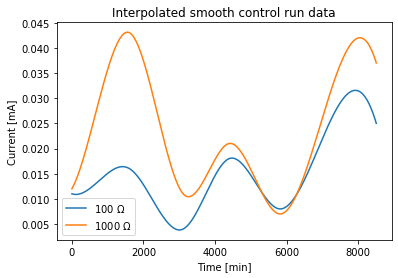

In [47]:
xnewc = np.linspace(ΔTc.min(), ΔTc.max(), 300)  

spl100c = make_interp_spline(ΔTc, mAc_100ohm, k=3)
spl1000c = make_interp_spline(ΔTc, mAc_1000ohm, k=3)
smooth100ohmc = spl100c(xnewc)
smooth1000ohmc = spl1000c(xnewc)

plt.plot(xnewc, smooth100ohmc, label = '100 $\Omega$')
plt.plot(xnewc, smooth1000ohmc, label = '1000 $\Omega$')
plt.xlabel('Time [min]')
plt.ylabel('Current [mA]')
plt.title('Interpolated smooth control run data')
plt.legend()

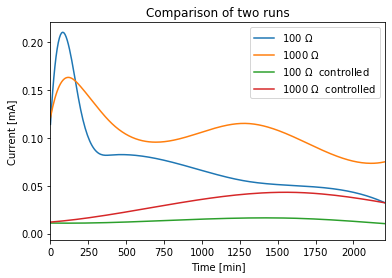

In [48]:
plt.plot(xnew, smooth100ohm, label = '100 $\Omega$')
plt.plot(xnew, smooth1000ohm, label = '1000 $\Omega$')
plt.plot(xnewc, smooth100ohmc, label = '100 $\Omega$  controlled')
plt.plot(xnewc, smooth1000ohmc, label = '1000 $\Omega$  controlled')
plt.xlabel('Time [min]')
plt.ylabel('Current [mA]')
plt.title('Comparison of two runs')
plt.xlim(0,2210)
plt.legend()

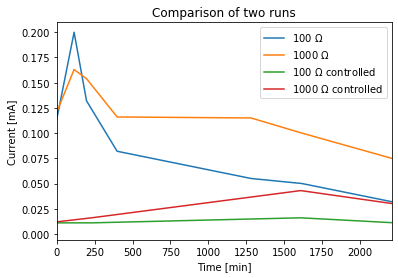

In [49]:
plt.plot(ΔT, mA_100ohm, label = '100 $\Omega$')
plt.plot(ΔT, mA_1000ohm, label = '1000 $\Omega$')
plt.plot(ΔTc, mAc_100ohm, label = '100 $\Omega$ controlled')
plt.plot(ΔTc, mAc_1000ohm, label = '1000 $\Omega$ controlled')
plt.xlabel('Time [min]')
plt.ylabel('Current [mA]')
plt.title('Comparison of two runs')
plt.xlim(0,2210)
plt.legend()

It is clear from the above figures that the anode, with the lead-based culture biofilm, produced more current than the controlled run produced. The current produced from the controlled run can be attributed to electro-active bacteria from the atomsphere. The cyclic nature of the controlled run can be explained as the random bacteria from the atmosphere producing current or meassurement noise and internal current.

The smooth graphs are only for visual interpretation and not real experimental data, as values have been interpolated.

# Experimental fit

An experimental fit will be attempted by changing the initial parameters of the two model methods. The models will be fitted to the 1000 $\Omega$ experimental data, to produce values of $\mu_{max}$, $\delta$ $(P/O_{NADH})$, $\alpha$ and the resistance. The initial 400 min (6 hrs 40 min) of the experimental data can be attributed to the dynamics of the MFC and will not be considered. The figure below will be used to fit the models.

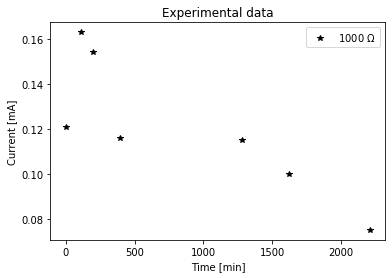

In [50]:
plt.plot(ΔT, mA_1000ohm, 'k*', label = '1000 $\Omega$')
plt.xlabel('Time [min]')
plt.ylabel('Current [mA]')
#plt.xlim(398,2250)
plt.title('Experimental data')
plt.legend()

Using the initial values from the experiment,

- 8.11 g glucose
- 1.9 L solution

the models will be fitted to the experimental data. The models will be fitted by using sliders from the `interact` module from the `ipywidgets` library.

## Method 1 fit

In [51]:
from scipy.integrate import odeint
from numpy import linspace
from ipywidgets import interact

MMX = 1*12 + 1.8*1 + 0.5*16 + 0.2*14
K_M = 0.001
γ = 2.4

c_S_0 = (8.11/1.9)/30
c_X_0 = 0.001/MMX
c_H_0 = 0/1
V_0 = 1.9

In [52]:
def func(mu_max = 0.22, δ = 0.8, α = 0.08, R = 18000):
    
        
    V_max = 2.07 #V
    I_max = V_max/R
    N_elec_max = I_max/1.60217646e-19
    F_H_max = N_elec_max/6.022e23
    r_H_max = F_H_max/((1/60)*(1/60))
    r_O_max = -r_H_max/4
    
    
    def rates(var):
        c_S, c_X, c_C, c_E, c_O, c_W, V = var

        mu = mu_max*c_S/((K_M/1000) + c_S)

        S_base = np.matrix([[1,    0,    1,     1,    1,    0,   0],
                            [2,    3,    1.8,   0,    3,    0,   2],
                            [1,    0,    0.5,   2,    0.5,  2,   1],
                            [0,    1,    0.2,   0,    0,    0,   0]])
    #                        rS,   rA,   rX,    rC,   rE    rO,  rW
    #                        r[0], r[1], r[2],  r[3], r[4]  r[5] r[6]

        S_spec = [1, 0, 0, 0, 0, 0, 0] # S0
        A_spec = [0, 1, 0, 0, 0, 0, 0] # S1
        X_spec = [0, 0, 1, 0, 0, 0, 0] # S2
        C_spec = [0, 0, 0, 1, 0, 0, 0] # S3
        E_spec = [0, 0, 0, 0, 1, 0, 0] # S4
        O_spec = [0, 0, 0, 0, 0, 1, 0] # S5
        W_spec = [0, 0, 0, 0, 0, 0, 1] # S6
        Resp_spec = [0, 0, -α, 1, -1/2, -1, 0]
        Energy_spec =  [0, 0, -γ, 2/3, 1, -2*δ, 0]

        S1 = np.vstack([S_base, X_spec, E_spec, Resp_spec])
        C1 = np.array([0, 0, 0, 0, mu, 0, 0]).T
        r = np.linalg.solve(S1, C1)

        if c_S > 0.000001:

            if r_O_max < r[5]*c_X*V:
                return r

            else:
                S2 = np.vstack([S_base, O_spec, Resp_spec, Energy_spec])
                C2 = np.array([0, 0, 0, 0, r_O_max/c_X/V, 0, 0]).T
                r = np.linalg.solve(S2, C2)
                return r

        else:
            S3 = np.vstack([S_base, S_spec, X_spec, E_spec])
            C3 = np.array([0, 0, 0, 0, 0, 0, 0]).T
            r = np.linalg.solve(S3, C3)
            return r

    def ferm(var, t):
        c_S, c_X, c_C, c_E, c_O, c_W, V = var

        r_S, r_A, r_X, r_C, r_E, r_O, r_W = rates(var)

        dc_Sdt = r_S*c_X
        dc_Xdt = r_X*c_X
        dc_Cdt = r_C*c_X
        dc_Edt = r_E*c_X
        dc_Odt = r_O*c_X
        dc_Wdt = r_W*c_X
        dVdt = 0

        return dc_Sdt, dc_Xdt, dc_Cdt, dc_Edt, dc_Odt, dc_Wdt, dVdt

    c_i_0 = [c_S_0, c_X_0, 0, 0, 0, 0, V_0]
    tspan = np.linspace(0.000001, 50, 1001)

    c_i = odeint(ferm, c_i_0, tspan)
    c_S, c_X, c_C, c_E, c_O, c_W, V = c_i.T


    list_rO = []

    for i in range(0, len(c_S)):
        r_S, r_A, r_X, r_C, r_E, r_O, r_W = rates([c_S[i], c_X[i], c_E[i], c_O[i], c_C[i], c_W[i], V[i]])
        list_rO.append(r_O) 

    r_O = np.array(list_rO)

    F_H = (-4*r_O)*c_X*V*(1/60)*(1/60)
    H_atoms = F_H*6.022e23
    N_electrons = H_atoms
    Coulomb_per_second = N_electrons*1.60217646e-19

    Ampere = Coulomb_per_second

    plt.plot(tspan, Ampere, label = 'Model fit')
    plt.plot((ΔT/60), (mA_1000ohm/1000), 'k*', label = 'Experimental data')
    plt.ylabel('Amperes [A]')
    plt.xlabel('Time [h]')
    plt.legend()
    plt.show()

In [53]:
interact(func, mu_max = (0, 0.5, 0.01), δ = (0.5, 2.5, 0.1), α = (0.01,0.1,0.01), R = (500,20000,500))
plt.show()

interactive(children=(FloatSlider(value=0.22, description='mu_max', max=0.5, step=0.01), FloatSlider(value=0.8…

The main area of focus would be to fit the maximum current produced 'plateau' to the constant current produced from the experimental data, between 6 hours and 21 hours. As stated above, the values of the experimental data before the 6 hour mark can be attributed to the dynamics of the MFC. The following parameters were found to fit the data the best for method 1, the component balance, 

- $\mu_{max}$ = 0.28 [$\frac{1}{h}$]
- $\delta$ ( $(P/O)_{NADH}$ ) = 0.8
- $\alpha$ = 0.08
- $R$ = 18000 $\Omega$

## Method 2

In [54]:
from scipy.optimize import fsolve
MMX = 1*12 + 1.8*1 + 0.5*16 + 0.2*14

mu_max = 0.3
K_M = 0.004

δ = 0.5
γ = 2.4

θ = 0.1

c_S_0 = 10/30
c_X_0 = 0.001/MMX
c_H_0 = 0/1
V_0 = 1

In [55]:
def func(mu_max = 0.25, δ = 0.8, α = 0.09, R = 18000):
    
    V_max = 2.07 #V
    I_max = V_max/R
    N_elec_max = I_max/1.60217646e-19
    F_H_max = N_elec_max/6.022e23
    r_H_max = F_H_max/((1/60)*(1/60))
    r_O_max = -r_H_max/4
    
    def beta(β):
        nul1 = (1 + α)*4 - ((4 + 1*1.8 - 2*0.5 - 3*0.2) + 2*β)
        return nul1
    
    β = fsolve(beta, α)[0]
    
    def rates(var):
        c_S, c_X, c_C, c_E, c_O_flux = var

        mu = mu_max*c_S/(K_M + c_S)

        S_base = np.matrix([[-1,   1+α,    1,    3/2,    0],
                            [0,    β,      2,    0,    -2],
                            [0,    -γ,   2/3,    1,   2*δ]])
    #                       rS,    rX,    rC,   rE,   rO
    #                       r[0], r[1], r[2],  r[3], r[4] 

        S_spec = [1, 0, 0, 0, 0] # S0
        X_spec = [0, 1, 0, 0, 0] # S1
        C_spec = [0, 0, 1, 0, 0] # S2
        E_spec = [0, 0, 0, 1, 0] # S3
        O_spec = [0, 0, 0, 0, 1] # S4
        Resp_spec = [0, 0, 1, 0, 1]   

        S1 = np.vstack([S_base, X_spec, Resp_spec])
        C1 = np.array([0, 0, θ, mu, 0]).T
        r = np.linalg.solve(S1, C1)  

        if -r_O_max > r[4]*c_X:
            return r

        else:
            S2 = np.vstack([S_base, O_spec, Resp_spec])
            C2 = np.array([0, 0, θ, -r_O_max/c_X, 0]).T
            r = np.linalg.solve(S2, C2)

        return r

    def ferm(var, t):
        c_S, c_X, c_C, c_E, c_O_flux = var

        r_0, r_1, r_2, r_3, r_4 = rates(var)

        if c_S < 0.000001:
            r_0, r_1, r_2, r_3, r_4 = 0, 0, 0, 0, 0

        r_S = -r_0
        r_X = r_1
        r_C = α*r_1 + r_2 + 1/2*r_3
        r_E = r_3
        r_O_flux = -r_4

        dc_Sdt = r_S*c_X
        dc_Xdt = r_X*c_X
        dc_Cdt = r_C*c_X
        dc_Edt = r_E*c_X
        dc_Odt = r_O_flux*c_X
        dVdt = 0

        return dc_Sdt, dc_Xdt, dc_Cdt, dc_Edt, dc_Odt

    c_i_0 = [c_S_0, c_X_0, 0, 0, 0]
    tspan = np.linspace(0.000001, 50, 1001)

    c_i = odeint(ferm, c_i_0, tspan)
    c_S, c_X, c_C, c_E, c_O_flux = c_i.T

    list_rO = []

    for i in range(0, len(c_S)):
        r_0, r_1, r_2, r_3, r_4 = rates([c_S[i], c_X[i], c_C[i], c_E[i], c_O_flux[i]])

        if c_S[i] < 0.000001:
            r_0, r_1, r_2, r_3, r_4 = 0, 0, 0, 0, 0

        r_O_flux = -r_4

        list_rO.append(r_O_flux)

    r_O_flux = np.array(list_rO)

    F_H_f = (-4*r_O_flux)*c_X*(1/60)*(1/60)
    H_atoms_f = F_H_f*6.022e23
    N_electrons_f = H_atoms_f
    Coulomb_per_second_f = N_electrons_f*1.60217646e-19

    Ampere_f = Coulomb_per_second_f

    plt.plot(tspan, Ampere_f, label = 'Model fit')
    plt.plot((ΔT/60), (mA_1000ohm/1000), 'k*', label = 'Experimental data')
    plt.ylabel('Amperes [A]')
    plt.xlabel('Time [h]')
    plt.legend()
    plt.show()

In [56]:
interact(func, mu_max = (0, 0.5, 0.01), δ = (0.5, 2.5, 0.1), α = (0.01,0.1,0.01), R = (500,20000,500))
plt.show()

interactive(children=(FloatSlider(value=0.25, description='mu_max', max=0.5, step=0.01), FloatSlider(value=0.8…

Again, the aim is to fit the model to the experimental data between 6 and 21 hours. The following parameter were found to fit the data the best for method 2, the flux-balance model, 

- $\mu_{max}$ = 0.25 [$\frac{1}{h}$]
- $\delta$ ( $(P/O)_{NADH}$ ) = 0.8
- $\alpha$ = 0.09
- $R$ = 18000 $\Omega$

# Comparison and Conclusion of fitted models

The following table will qualitatively compare the 2 models' parameters as well as calculate an average value for the parameter. 

|   Parameter  	| Method 1 value 	| Method 2 value 	| Average value 	|          Units          	|
|:-----------:	|:--------------:	|:--------------:	|:-------------:	|:-----------------------:	|
| $\mu_{max}$ 	|      0.28      	|      0.22      	|     0.25     	|     [$\frac{1}{h}$]     	|
|   $\delta$  	|       0.8      	|       0.8      	|      0.8      	| [$\frac{mol ATP}{cmol X}$] 	|
|   $\alpha$  	|      0.08      	|      0.09      	|     0.085     	|                         	|
|     $R$     	|      18000     	|      18000     	|     18000     	|         $\Omega$        	|

The values of the parameters for the two separate models are very similiar. All the parameters have reasonable values, other than the resistance of the MFC. A specific maximum growth rate, $\mu_{max}$ of 0.25 $\frac{1}{h}$ is not absurdly high as [Pirt, 1966](https://www.microbiologyresearch.org/docserver/fulltext/micro/47/2/mic-47-2-181.pdf?expires=1593690920&id=id&accname=guest&checksum=DAA1E643EB77F9B1C238B8118CA81054) discovered *E. coli* and *K. aerogenes* can have a $\mu_{max}$ = 0.7 and $\mu_{max}$ = 0.72, respectively, when subjected to ideal conditions. As stated earlier, a $\delta$, $(P/O)_{NADH}$, of 0.8 is reasonable as the value should be between 0.5 and 2.5. Due to the ATP distribution in a MFC, the $\delta$, $(P/O)_{NADH}$, will never truely reach the maximum value of 2.5. The distribtion of glucose between the biomass and $CO_2$ value, $\alpha$, is also rational as a value of $\alpha$ = 0.1 is usually used. 

Now for the odd one out, the resistance of the MFC. For the models to fit the experimental data, a massive resistance of 18000 $\Omega$ resulted. Accoring to [Liang, *et al*, 2007](https://link.springer.com/article/10.1007/s00253-007-1193-4), there exists three types of internal resistances encountered in electrochemical cells. The resistances include the 'ohmic resistance', the 'activation overpotentials' and the 'diffusion resistance'. [Liang, *et al*, 2007](https://link.springer.com/article/10.1007/s00253-007-1193-4), then goes on to describe the diffusional resistance as the resistance created between the anode's and cathode's electrical charges. As a single-chamber MFC was used to produce the experimental data, care should have been taken to isolate the electrical charges of the electrodes by using vermiculite, for example. Vermiculite was bought and ready for the second run, but due to COVID-19, a second run was not possible. This could be the reason for the high fitted resistance value as the two electrodes were only 20 cm apart, with no membrane to lower the resistance. Another reason for the high resistance could be incorrect measurement of the internal resistance of the electrodes when the experiment was conducted. As there is no way to get onto campus, due to the pandemic, it is impossible to remeasure the internal resistance of the electrodes.

Other than the high fitted resistance values, all the other parameters are reasonable and the models provide a good fit. A better fit would have been obtained if more experiments could have been conducted as well as reasoning for the high fitted-resistance value.